## Supervised Learning using a Neural Network Classifier on IMDB Movie Reviews 

For a final project, I was tasked with exploring IMDB movie review dataset and training a neural network classifier to predict positive or negative scores, based solely on the text from the reviewer. I worked primarily in numpy and sklearn libraries, but also learned to use tensorflow, keras, and SBERT (Sentence Transformers) for this project.   

Below documents my reasoning process and the models I tried in exploring this dataset. Performance for each model in terms of training accuracy, testing accuracy, and validation accuracy are included at the bottom of this notebook.



## Importing necessary packages

In [6]:

# Imports taken from previous homeworks 


import numpy as np
import matplotlib.pyplot as plt

import os

import torch

# Tokenization 

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

import keras 
from keras import layers 

# SBERT 
from sentence_transformers import SentenceTransformer as ST

# Grid Search to optimize hyperparameters & alpha for L2 Regularization
from sklearn.model_selection import GridSearchCV as grids

# Padding 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# cross validation score

from sklearn.model_selection import cross_val_score

from scikeras.wrappers import KerasClassifier

# Sequential model 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout

from IPython import display

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split as tts # validation tools
from sklearn.metrics import accuracy_score

from sklearn.neural_network import MLPClassifier as mlp    # scikit's MLP

import warnings
warnings.filterwarnings('ignore')

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)  
torch.manual_seed(seed);

### Function to load review data: So far only training data has been loaded 

In [7]:
# need to import the data somehow 
# PATH: ./aclImdb/train

def load_reviews(data_path):
    reviews = []  # store the review texts
    ratings = []  # store the ratings
    labels = []   # store the labels (1 for pos, 0 for neg)
    
    # Iterate through the 'pos' and 'neg' folders
    for label, sentiment in enumerate(['neg', 'pos']):
        folder_path = os.path.join(data_path, sentiment)  # Path to 'neg' or 'pos'
        
        # Iterate through all the files in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):  # Ensure it's a .txt file
                # Extract the review text
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                    reviews.append(f.read())
                
                # Extract the rating from the filename
                rating = int(filename.split('_')[1].split('.')[0])  # Parse the rating from the filename
                ratings.append(rating)
                
                # Assign the label (0 for 'neg', 1 for 'pos')
                labels.append(label)

    # Return as numpy arrays
    return np.array(reviews), np.array(ratings), np.array(labels)


## Understanding the dataset 

In [8]:
# Path to the dataset
data_path = './aclImdb/train'

# Load the reviews, ratings, and labels
reviews, ratings, labels = load_reviews(data_path)

# Check the data
print("Number of reviews:", len(reviews))
print("Sample review:", reviews[0])
print("Sample rating:", ratings[0])
print("Sample label (0=neg, 1=pos):", labels[0])

Number of reviews: 25000
Sample review: Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.
Sample rating: 4
Sample label (0=neg, 1=pos): 0


Text(0, 0.5, 'Count')

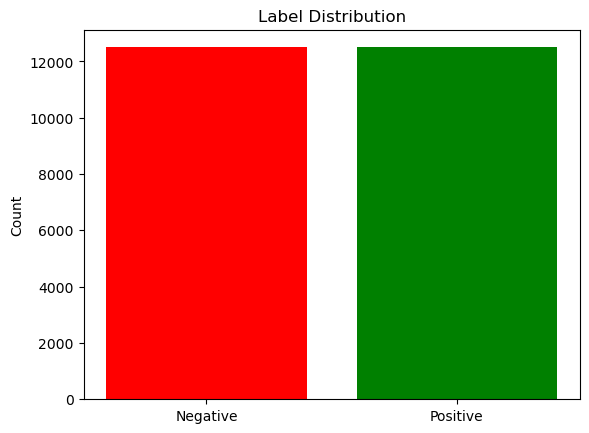

In [9]:
# Count positive and negative labels
label_counts = np.bincount(labels)

# Plot distribution
plt.bar(['Negative', 'Positive'], label_counts, color=['red', 'green'])
plt.title('Label Distribution')
plt.ylabel('Count')

Average review length: 233.79 words
Median review length: 174.00 words


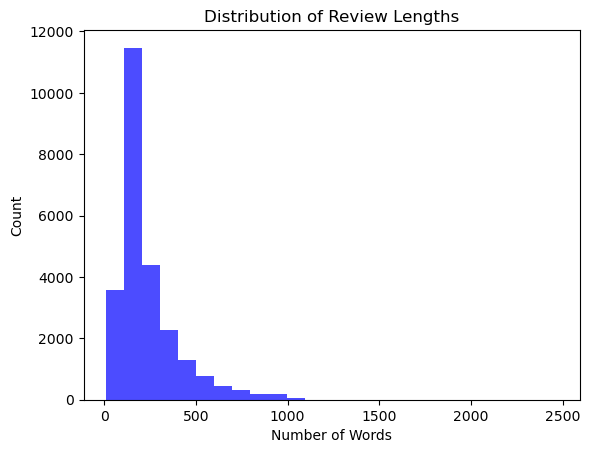

In [10]:
# Compute the lengths of reviews
review_lengths = [len(review.split()) for review in reviews]

# Plot histogram
plt.hist(review_lengths, bins=25, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Count')

# average & median review lengths 
print(f"Average review length: {np.mean(review_lengths):.2f} words")
print(f"Median review length: {np.median(review_lengths):.2f} words")

We can see that there are 25000 data points in the training dataset for IMDB movie reviews. Each review is formatted with the id and actual rating, and within each text file is the word contents of the review. Each positive and negative reviews make up half of the dataset(12500 data points). The data is primarily skewed left, so it would make sense to use the **median** rather than the mean to describe the distribution of words per review. 

### Defining Stopwords and removing them from the positive/negative review data points. 

Investigating which are the most common words used in positive/negative reviews. Accounting for neutral or "filler words" known as stop words that do not add value to the tokenization and thus removing them for feature transformation. 

In [11]:

import nltk
from collections import Counter
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = set(stopwords.words('english'))


# Define stopwords set - this is too tedious on its own, using NLTK stopwords set AND custom set
custom = {'/><br', 'movie', 'film', 'one', 'would', 'even', 'see', '-', 'get', 'people','make', 'also', 'first', '/>the'}

all_stop = stop.union(custom)

# Function to filter stopwords from a review
def filter_stopwords(text):
    words = text.split()
    return [word.lower() for word in words if word.lower() not in all_stop]

# Filter entire dataset
filtered_reviews = [" ".join(filter_stopwords(review)) for review in reviews]

# Count word frequencies in all reviews
all_words = Counter(" ".join(filtered_reviews).split())

# Most common words overall
print("Most common words:", all_words.most_common(10))

# Separate reviews by sentiment
neg_reviews = [filtered_reviews[i] for i in range(len(filtered_reviews)) if labels[i] == 0]
pos_reviews = [filtered_reviews[i] for i in range(len(filtered_reviews)) if labels[i] == 1]

# Count words in each sentiment category
neg_words = Counter(" ".join(neg_reviews).split())
pos_words = Counter(" ".join(pos_reviews).split())

# Display results
print("Top negative words:", neg_words.most_common(10))
print("Top positive words:", pos_words.most_common(10))


[nltk_data] Downloading package stopwords to /Users/ms/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most common words: [('like', 18779), ('good', 11926), ('really', 11065), ('story', 8743), ('much', 8739), ('time', 7945), ('great', 7714), ('could', 7594), ('made', 7041), ('bad', 6816)]
Top negative words: [('like', 10458), ('good', 5845), ('really', 5806), ('bad', 5335), ('much', 4524), ('could', 4487), ('time', 3955), ('made', 3800), ('story', 3710), ('think', 3406)]
Top positive words: [('like', 8321), ('good', 6081), ('great', 5504), ('really', 5259), ('story', 5033), ('much', 4215), ('time', 3990), ('well', 3803), ('best', 3733), ('many', 3617)]


Still need to generate features without these stop words

## Comparing vocabulary-based approach to pretrained (SBERT) embeddings

### Need to convert the reviews -> integers for NN use. Will use Tokenize to convert from text into integer data

In [12]:
# Step 1: Initialize the TextVectorization layer
vectorizer = TextVectorization(
    max_tokens=10000,  # Maximum vocabulary size
    output_sequence_length=200  # Fixed-length sequences
)

# Step 2: Fit the TextVectorization layer on the text data
vectorizer.adapt(reviews)

# Step 3: Transform the text data into sequences
text_sequences = vectorizer(reviews)
                

In [13]:
# Display a sample vectorized review
print("First tokenized review:", text_sequences[0].numpy())

First tokenized review: [ 795   17   29    5    2  115 2233 7017   11   20  980    6   28    1
    6   30 2388 1789  124 2223    6    4 6906 5288   13 3306 2286    2
   20   36  486    1 3392    3  213    4 1019  177   21   50  801    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   

Note: It does not make sense here to standardize our training data for vocab based approach because this data represents categorical values (word IDs) and not numerical features. Standardization assumes a continuous numerical range with meaningful distances.

### 80-20 Train Test Split (on Training Data) for Vocabulary based approach

In [14]:
# do train test split on current training data 80-20 split - shortened as tts 

# tr - Training data, ts - Testing Data 
# X are the reviews, y are the labels (0 or 1) to indicate if negative or positive review
X_tr, X_ts, y_tr, y_ts = tts(text_sequences.numpy(), labels, test_size=0.2, random_state=1234)

print("Training data shape:", X_tr.shape) # 20,000 Reviews with 200 Labels 
print("Testing data shape:", X_ts.shape) # 5000 Reviews with 200 Labels


Training data shape: (20000, 200)
Testing data shape: (5000, 200)


### This will be setting up the Neural Network with the Training data that is split into 80% training, 20% validation data

In [15]:

import time # tracking execution time 
tic = time.time()

# Do training on increments of data sizes. 
train_sizes = [100, 200, 500, 1000, 2500, 5000, 10000, 20000]

# Arrays to hold training and validation error 
tr_err_adam = []
te_err_adam = []

for m_tr in train_sizes:
    ### YOUR CODE STARTS HERE
    
    # select subset of data for training data 
    X_train_subset = X_tr[:m_tr]
    y_train_subset = y_tr[:m_tr]
    
    
    # define MLP 
    adam_model = mlp(
        hidden_layer_sizes=(256, 128,64),  # 64 Hidden nodes - 1 hidden layer 
        activation='relu', # ReLU activation function 
        solver='adam', # Train using adam
        learning_rate_init=0.0001,
        batch_size=256,   
        max_iter=300,
        early_stopping=True,
        
        random_state=seed 
    )
    
    # fit MLP model on subset
    adam_model.fit(X_train_subset, y_train_subset)
    
    # calculate training error 
    tr_accuracy = adam_model.score(X_train_subset, y_train_subset)
    tr_err_adam.append(1 - tr_accuracy)
    
    # calculate testing error 
    te_accuracy = adam_model.score(X_ts, y_ts)
    te_err_adam.append(1 - te_accuracy)
    
    print(f'Total elapsed time: {time.time()-tic} for {m_tr} data points')
    print(f'Training Error: {tr_accuracy:.2f}')
    print(f'Testing Error: {te_accuracy:.2f}')
    print("_________________________________________________________________")


Total elapsed time: 0.19567012786865234 for 100 data points
Training Error: 0.46
Testing Error: 0.50
_________________________________________________________________
Total elapsed time: 0.3907041549682617 for 200 data points
Training Error: 0.54
Testing Error: 0.50
_________________________________________________________________
Total elapsed time: 0.7902841567993164 for 500 data points
Training Error: 0.53
Testing Error: 0.51
_________________________________________________________________
Total elapsed time: 1.0535979270935059 for 1000 data points
Training Error: 0.49
Testing Error: 0.50
_________________________________________________________________
Total elapsed time: 1.9587681293487549 for 2500 data points
Training Error: 0.51
Testing Error: 0.50
_________________________________________________________________
Total elapsed time: 4.5705039501190186 for 5000 data points
Training Error: 0.50
Testing Error: 0.50
_________________________________________________________________


In [16]:
# before we plot, its good to check cross validation that the model has trained properly

# Trying Cross Validation with MLP adam solver Model See if it improves 
adam_classifier = KerasClassifier(model=adam_model,verbose=0)

adam_cv_scores = cross_val_score(adam_model, X_tr, y_tr,cv=5, scoring='accuracy')

# Print results
print(f"Cross-Validation Scores: {adam_cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(adam_cv_scores):.4f}")

Cross-Validation Scores: [0.49675 0.49725 0.51375 0.49175 0.497  ]
Mean Cross-Validation Accuracy: 0.4993


Text(0.5, 1.0, 'Training and Testing Error vs. Number of Training Examples')

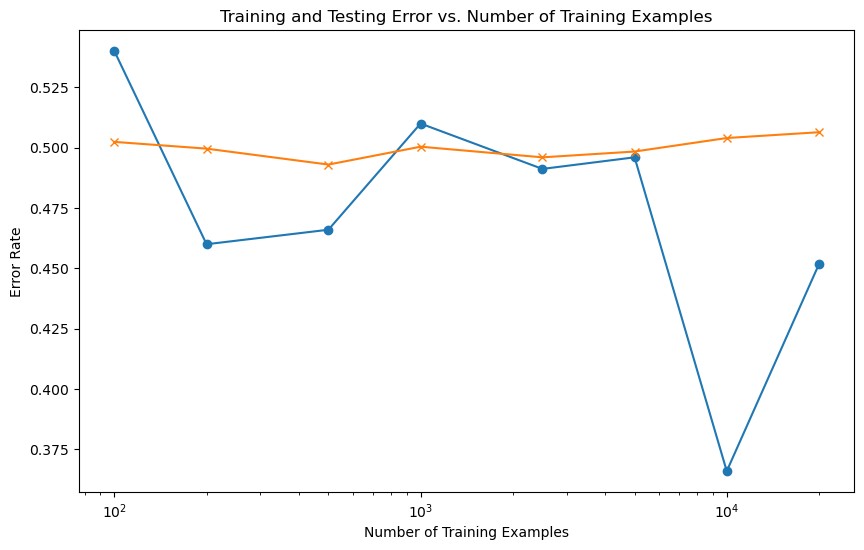

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, tr_err_adam, label='Training Error', marker='o')
plt.plot(train_sizes, te_err_adam, label='Testing Error', marker='x')
plt.xscale('log')
plt.xlabel('Number of Training Examples')
plt.ylabel('Error Rate')
plt.title('Training and Testing Error vs. Number of Training Examples')


Realized that since the text encodings are padded with 0's to ensure the same length, MLPClassifier(Multi-layered perceptron) treats each data point equally (including the 0's) which is why the model is not performing well. Will need to switch to a different model -> considering tensorflow/keras sequential NN model

### Trying with SBERT 

The reason why SBERT works with MLPClassifier because SBERT generates continuous embeddings with a fixed length which does not need padding and these are numerical features. 

In [18]:
#SETUP For PreTrained SBERT 
# Lightweight SBERT model 
sbert_model = ST('all-MiniLM-L6-v2')

sentence_embed = sbert_model.encode(reviews)

print("Shape of embeddings:", sentence_embed.shape)  # Should be (batch_size, 384)

Shape of embeddings: (25000, 384)


## 80-20 Train Test Split of SBERT Embeddings

In [19]:
# Train test split as tts 

# Split into training and testing sets
X_train, X_test, y_train, y_test = tts(sentence_embed, labels, test_size=0.2, random_state=seed)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (20000, 384)
Testing set shape: (5000, 384)


In [20]:
# define MLP 
sbert_model = mlp(
    hidden_layer_sizes=64,  # 64 Hidden nodes - 1 hidden layer 
    activation='relu', # ReLU activation function 
    solver='sgd', # Train using SGD and learning rate = 0.001 
    learning_rate_init=0.001,
    batch_size=256,   # batch size = 256
    max_iter=50,
    random_state=seed #random_state=seed
)
    
# fit MLP model on subset
sbert_model.fit(X_train, y_train)

MLPClassifier(batch_size=256, hidden_layer_sizes=64, max_iter=50,
              random_state=1234, solver='sgd')

In [21]:
# Cross validation for this model to see if it is trained and split properly

# Trying Cross Validation with MLP SBERT Model See if it improves 
sbert_classifier = KerasClassifier(model=sbert_model,verbose=0)

sbert_cv_scores = cross_val_score(sbert_model, X_tr, y_tr,cv=5, scoring='accuracy')

# Print results
print(f"Cross-Validation Scores: {sbert_cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(sbert_cv_scores):.4f}")


Cross-Validation Scores: [0.499   0.4995  0.49975 0.49925 0.49975]
Mean Cross-Validation Accuracy: 0.4995


### Testing and evaluating accuracy on the test data

In [22]:
# Evaluate the model on the test set
accuracy = sbert_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7568


### Want to implement L2 Regularization to Improve results: 

In [23]:
# define MLP 
new_sbert_model = mlp(
    hidden_layer_sizes=(128, 64),  # 64 Hidden nodes - 128 hidden layers 
    activation='relu', # ReLU activation function 
    solver='sgd', # Train using SGD and learning rate = 0.001 
    learning_rate_init=0.001,
    alpha=0.01, #L2 Regularization strength 
    batch_size=256,   
    max_iter=50,
    random_state=seed 
)
    
# fit MLP model on subset
new_sbert_model.fit(X_train, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(128, 64),
              max_iter=50, random_state=1234, solver='sgd')

In [24]:
# Evaluate the model on the test set
accuracy = new_sbert_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.763


### Optimize hyper parameters & Alpha for L2 Regularization through GridSearchCV

In [25]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(128,), (128, 64)],  # Different layer sizes
    'alpha': [0.0001, 0.001, 0.01],                 # Regularization strengths
    'solver': ['sgd'],                                  # Optimizers
    'learning_rate_init': [0.001, 0.01], # Learning rates
    'batch_size': [128]
}

# Grid search for MLPClassifier - grids & mlp for shorter
grid_search = grids(
    mlp(max_iter=100, early_stopping=True, random_state=seed),
    param_grid,
    cv=3,  # 3-fold cross-validation
    verbose=1,    
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Best Model Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'alpha': 0.01, 'batch_size': 128, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01, 'solver': 'sgd'}
Best Model Test Accuracy: 0.821


In [26]:
# Cross validation for this model to see if it is trained and split properly

# Trying Cross Validation with optimized MLP SBERT Model See if it improves 
best_classifier = KerasClassifier(model=best_model,verbose=0)

sbert_cv_scores = cross_val_score(best_model, X_tr, y_tr,cv=5, scoring='accuracy')

# Print results
print(f"Cross-Validation Scores: {sbert_cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(sbert_cv_scores):.4f}")

Cross-Validation Scores: [0.501   0.50075 0.5005  0.50025 0.5005 ]
Mean Cross-Validation Accuracy: 0.5006


In [27]:
t_pred = best_model.predict(X_train)
print("Best Model Training Accuracy:", accuracy_score(y_train, t_pred))

Best Model Training Accuracy: 0.86775


### Trying new Sequential Model

it seems that although test/training performance is higher with SBERT, its still performing bad on cross validation.

In [28]:
# Load SBERT model
sbert_model = ST('all-MiniLM-L6-v2')

# Example IMDB Reviews Data
X_train, X_test, y_train, y_test = tts(reviews, labels, test_size=0.2, random_state=42)

# Convert Reviews to SBERT Embeddings
X_train_embeddings = sbert_model.encode(X_train, convert_to_tensor=True)
X_test_embeddings = sbert_model.encode(X_test, convert_to_tensor=True)

In [29]:
# Force CPU Usage - otherwise having errors with tensorflow and numpy arrays 
device = torch.device("cpu")
X_train_embeddings = X_train_embeddings.to(device)
X_test_embeddings = X_test_embeddings.to(device)

In [30]:
# need to define model in a function to wrap it 
def create_keras_model(activation='relu', optimizer='sgd', batch_size=16, epochs=20): 
    # Define Sequential Model
    s_model = Sequential([
        Dense(256, activation=activation, input_shape=(384,)),
        Dropout(0.3),
        Dense(128, activation=activation),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Binary Classification
    ])

    # Compile the Model
    s_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return s_model

wrapped_model = KerasClassifier(model=create_keras_model, epochs=10, batch_size=32, verbose=0)


In [31]:
# Perform Cross-Validation on Training Data
cv_scores = cross_val_score(wrapped_model, X_train_embeddings, y_train, cv=5, scoring='accuracy')

# Print Cross-Validation Results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Scores: [0.81375 0.809   0.81275 0.81525 0.828  ]
Mean Cross-Validation Accuracy: 0.8158


Seeing if I can optimize these parameters first using gridsearchCV

In [33]:
# Define the Parameter Grid
param_grid = {
    "model__batch_size": [16, 32, 64],
    "model__epochs": [5, 10, 20],
    "model__optimizer": ["adam", "sgd"],
    "model__model__activation": ["relu", "tanh", "sigmoid"]
}

# Perform Grid Search
grid = grids(estimator=wrapped_model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(X_train_embeddings, y_train)

# Display Best Results
print("Best Hyperparameters:", grid_result.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_result.best_score_:.4f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Hyperparameters: {'model__batch_size': 64, 'model__epochs': 10, 'model__model__activation': 'sigmoid', 'model__optimizer': 'sgd'}
Best Cross-Validation Accuracy: 0.8160


In [34]:
ideal_smodel = Sequential([
    Dense(256, activation='relu', input_shape=(384,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),# Binary Classification
])

# Compile the Model
ideal_smodel.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
ideal_smodel.summary()

# Assuming X_train, y_train are defined as your dataset
history = ideal_smodel.fit(X_train_embeddings, y_train, epochs=20, batch_size=16, validation_data=(X_test_embeddings, y_test))

Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_507 (Dense)               │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_338 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_339 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,585 (514.00 KB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5494 - loss: 0.6898 - val_accuracy: 0.7248 - val_loss: 0.6711
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6678 - loss: 0.6632 - val_accuracy: 0.7596 - val_loss: 0.6089
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7216 - loss: 0.5957 - val_accuracy: 0.7814 - val_loss: 0.5107
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7569 - loss: 0.5156 - val_accuracy: 0.7912 - val_loss: 0.4573
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7709 - loss: 0.4783 - val_accuracy: 0.7982 - val_loss: 0.4387
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7905 - loss: 0.4533 - val_accuracy: 0.8008 - val_loss: 0.4313
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7899 - loss: 0.4508 - val_accuracy: 0.8086 - val_loss: 0.4189
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7950 - loss: 0.4432 - 

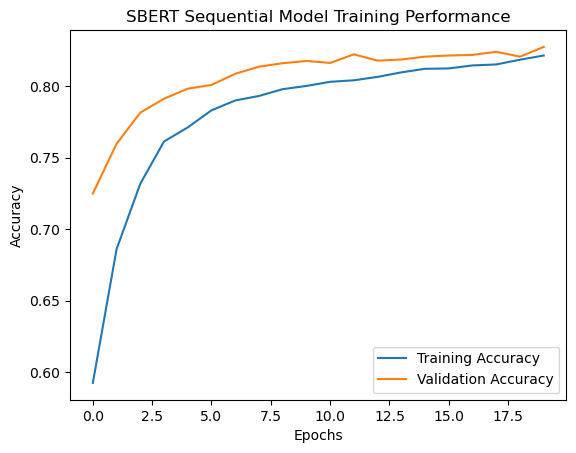

In [35]:
# Plot Training Performance
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("SBERT Sequential Model Training Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


### Using Ensemble Methods along with Optimized Hyperparameters: 

In [36]:
from sklearn.ensemble import VotingClassifier # using Voting to merge together
from sklearn.ensemble import RandomForestClassifier as rfc 

# using our optimal ideal_smodel from earlier, we also need to wrap it. 
wrapped_smodel = KerasClassifier(
    model=create_keras_model, 
    epochs=20,
    batch_size=16,
    verbose=0
)

# will be using random forests as ensemble
random_forest = rfc(n_estimators=100, random_state=seed)

s_ensemble = VotingClassifier(estimators=[('random_forest', random_forest), ('optimal_mlp', wrapped_smodel)], voting='soft')
s_ensemble.fit(X_train_embeddings, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(random_state=1234)),
                             ('optimal_mlp',
                              KerasClassifier(batch_size=16, epochs=20, model=<function create_keras_model at 0x2cdfed4e0>, verbose=0))],
                 voting='soft')

In [37]:
# Perform Cross-Validation
cv_scores = cross_val_score(s_ensemble, X_train_embeddings, y_train, cv=5, scoring='accuracy')

# Print Cross-Validation Results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Scores: [0.81725 0.81125 0.80825 0.8135  0.82525]
Mean Cross-Validation Accuracy: 0.8151


In [38]:
# Evaluate the Ensemble
ensemble_score = s_ensemble.score(X_test_embeddings, y_test) 
print(f"Ensemble Test Accuracy: {ensemble_score:.4f}") # This is slightly better, 0.8316

train_score = s_ensemble.score(X_train_embeddings, y_train) 
print(f"Ensemble Training Accuracy: {train_score:.4f}")


Ensemble Test Accuracy: 0.8332
Ensemble Training Accuracy: 0.9981


### Trying Gradient Boosting Model to see if we can improve on NN SBERT model 

In [39]:
### taking prediction values from the SBERT Keras model and put into gradient boost 
from xgboost import XGBClassifier as XGBC

# Define the Wrapped Keras Model (Optimized SBERT Model)
wrapped_smodel = KerasClassifier(
    model=create_keras_model, 
    epochs=20, 
    batch_size=16, 
    verbose=0
)

# init Gradient boost model
gb_model = XGBC(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed)

# Create the Ensemble Using Gradient Boosting
gensemble_model = VotingClassifier(
    estimators=[
        ('xgboost', gb_model), 
        ('optimal_mlp', wrapped_smodel)
    ], 
    voting='soft'
)

# Fit the Gradient Boosting Model
gensemble_model.fit(X_train_embeddings, y_train)

# Evaluate the Model
ensemble_score = gensemble_model.score(X_test_embeddings, y_test)
print(f"Ensemble Model Test Accuracy: {ensemble_score:.4f}")

# training accuracy
train_score = gensemble_model.score(X_train_embeddings, y_train)
print(f"Ensemble Model Train Accuracy: {train_score:.4f}")


Ensemble Model Test Accuracy: 0.8344
Ensemble Model Train Accuracy: 0.9890


In [42]:
# Trying Cross Validation with Gradient Boosting See if it improves 
gb_classifier = KerasClassifier(model=gensemble_model,verbose=0)

cv_scores = cross_val_score(gensemble_model, X_train_embeddings, y_train,cv=5, scoring='accuracy')

# Print results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")


Cross-Validation Scores: [0.8075  0.815   0.81675 0.815   0.8265 ]
Mean Cross-Validation Accuracy: 0.8162


### Loading the actual Test data from the IMDB library and compare to best model 

In [43]:
# Path to the dataset
data_path = './aclImdb/test'

# Load the reviews, ratings, and labels
t_reviews, t_ratings, t_labels = load_reviews(data_path)

# Check the data
print("Number of reviews:", len(t_reviews))
print("Sample review:", t_reviews[0])
print("Sample rating:", t_ratings[0])
print("Sample label (0=neg, 1=pos):", t_labels[0])

Number of reviews: 25000
Sample review: Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertaining performances by Rickman, Thompson, and Holbrook.
Sample rating: 4
Sample label (0=neg, 1=pos): 0


In [44]:
# Generate embeddings for the new test data
t_reviews_embeddings = sbert_model.encode(t_reviews)

In [45]:
# Make predictions using the SBert model
predictions = best_model.predict(t_reviews_embeddings)

# Convert probabilities to binary labels (if needed)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(t_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8116


In [46]:
# using Validation data to fit on SBERT Keras Sequential Model 

validation = ideal_smodel.fit(X_train_embeddings, y_train, epochs=20, batch_size=16, validation_data=(t_reviews_embeddings, t_labels))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8275 - loss: 0.3904 - val_accuracy: 0.8111 - val_loss: 0.4069
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8278 - loss: 0.3873 - val_accuracy: 0.8081 - val_loss: 0.4092
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8254 - loss: 0.3924 - val_accuracy: 0.8097 - val_loss: 0.4082
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8247 - loss: 0.3917 - val_accuracy: 0.8115 - val_loss: 0.4058
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8305 - loss: 0.3842 - val_accuracy: 0.8067 - val_loss: 0.4129
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8367 - loss: 0.3730 - val_accuracy: 0.8123 - val_loss: 0.4039
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8315 - loss: 0.3779 - val_accuracy: 0.8088 - val_loss: 0.4078
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8325 - loss: 0.3816 - 

slightly worse with the 25000 validation data points, but still pretty good...?

In [51]:
# Evaluate the Random Forest Ensemble
ensemble_score = s_ensemble.score(t_reviews_embeddings, t_labels) 
print(f"Random Forest Ensemble Validation Accuracy: {ensemble_score:.4f}") 

Random Forest Ensemble Validation Accuracy: 0.7889


In [50]:
# Evaluate the Gradient Boost Ensemble Model
gb_score = gensemble_model.score(t_reviews_embeddings, t_labels)
print(f"Ensemble Model Validation Accuracy: {ensemble_score:.4f}")

Ensemble Model Validation Accuracy: 0.7889


# Model Performance Table

Originally the training data (25,000 data points) was split 80-20 for 20,000 training and 5,000 test data.   
I then used the other testing data they provided (25,000 data points) as the validation data. 

| Model                                   | Cross Validation Score    | Training Accuracy  | Testing Accuracy | Validation Accuracy |
|-----------------------------------------|---------------------------|--------------------|------------------|---------------------|
| TextVectorization Multi-layered Perceptron model(model not good) |  51%  | 50%    | 50%     |    not worth evaluating      |
| SBERT with MLP Model                                             |  49%  | 86.78% | 82.10%  |   81.16% |
| SBERT with Keras Sequential Model(epoch=19 best)                 | 81.65%| 81.86% | 82.54%  |     81.38%     |  
| SBERT Sequential Random Forest                                   |   81.57%    | 99%(overfit) |  83.16%  |     78.89%     |
| SBERT Sequential Gradient Boost                                  | 81.55% |    99%  | 83%     |  78.89%     |